In [1]:
import tempfile
from pathlib import Path

import geopandas as gpd
import requests
from us import states
import pandas as pd
import contextily as ctx
from pandas_profiling import ProfileReport

from scipy.stats.stats import pearsonr
import seaborn as sns

In [2]:
## Inputs
DATA_DIR = Path("/Users/edward/Documents/race-covid/data")
CLEAN_DATA_DIR = DATA_DIR / 'clean'
OUTPUT_DATA_DIR = CLEAN_DATA_DIR / 'movement_data.parquet'

In [3]:
df = pd.read_parquet(OUTPUT_DATA_DIR)
df.head()

origin_census_block_group     10     11     12     13     14  \
0               170310101001  11.76  19.85  20.56  31.71  44.30   
1               170310101002  31.67  34.29  43.00  51.54  52.72   
2               170310101003  33.33  28.70  42.42  43.88  42.90   
3               170310102011  37.85  36.17  49.13  52.69  56.17   
4               170310102012  27.27  29.28  43.03  50.00  47.33   

   percent_unemployed  percent_nohs  white_perc  
0            5.970149     26.221080       61.82  
1            8.718861     16.792842       30.78  
2            4.806935      2.428571       69.78  
3            7.192575     12.510425       40.74  
4            2.306328     19.890909       60.41

In [4]:
top10_pre = df.sort_values(by=['10', '11']).head(800).origin_census_block_group
top10_post = df.sort_values(by=['12', '13', '14']).head(800).origin_census_block_group

In [5]:
df.rename(columns={"percent_unemployed": "Unemployment (%)", "white_perc": "Population: White (%)", "percent_nohs": "No High School Degree (%)"}).drop(["origin_census_block_group"], axis=1)

10     11     12     13     14  Unemployment (%)  \
0     11.76  19.85  20.56  31.71  44.30          5.970149   
1     31.67  34.29  43.00  51.54  52.72          8.718861   
2     33.33  28.70  42.42  43.88  42.90          4.806935   
3     37.85  36.17  49.13  52.69  56.17          7.192575   
4     27.27  29.28  43.03  50.00  47.33          2.306328   
...     ...    ...    ...    ...    ...               ...   
3978  26.58  34.40  50.42  49.17  44.21          0.000000   
3979  17.31  24.31  31.25  41.25  43.80         42.236025   
3980  25.93  25.41  45.65  51.65  52.78          2.981651   
3981  22.86  31.03  30.80  34.54  37.00          0.000000   
3982  28.79  25.96  38.78  52.63  47.68          5.000000   

      No High School Degree (%)  Population: White (%)  
0                     26.221080                  61.82  
1                     16.792842                  30.78  
2                      2.428571                  69.78  
3                     12.510425                  40.74  
4                     19.890909                  60.41  
...                         ...                    ...  
3978                  10.086957                   4.73  
3979                  29.562982                   2.62  
3980                   9.195402                  12.52  
3981                   2.879581                   8.17  
3982                  20.156250                   6.25  

[3980 rows x 8 columns]

In [6]:
#profile = ProfileReport(df.rename(columns={"percent_unemployed": "Unemployment (%)", "white_perc": "Population: White (%)", "percent_nohs": "No High School Degree (%)"}).drop(["origin_census_block_group"], axis=1), title='Pandas Profiling Report', explorative=True)
#profile

In [7]:
pearsonr(df.percent_unemployed, df['13'])

(-0.16965915110474084, 4.3639178106728724e-27)

/Users/edward/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


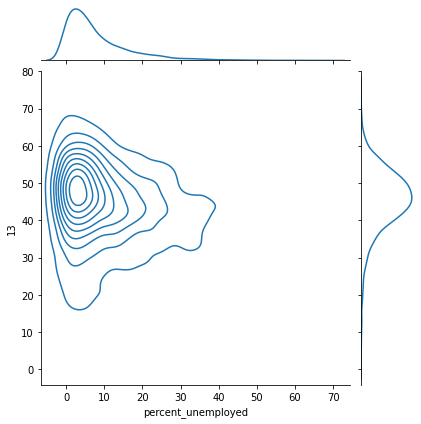

In [8]:
sns.jointplot(df.percent_unemployed, df['13'],kind='kde')

In [9]:
def get_shp_file(input_state: str, geography: str = "blockgroup") -> gpd.GeoDataFrame:
    """
    Retrieves the blockgroup shapefile using US python package
    Args:
        input_state: Name of state to look up
            For example "MA"
        geography: determines which shapefile to download
    Returns:
        The geo dataframe for the given state at the given geography level
    """
    url = states.lookup(input_state).shapefile_urls(geography)
    with tempfile.TemporaryDirectory() as tmpdir:
        tmpdir = Path(tmpdir)
        response = requests.get(url, stream=True)
        outfile_name = tmpdir / f"{input_state}.zip"
        with open(outfile_name, "wb") as outfile:
            for chunk in response.iter_content(chunk_size=8192):
                outfile.write(chunk)
        return gpd.read_file(f"zip://{outfile_name.absolute()}")


In [10]:
il_bkg = get_shp_file('IL')
# make sure we get the correct epsg
il_bkg = il_bkg.to_crs(epsg=3857)

In [11]:
cook_bcg = il_bkg[il_bkg.COUNTYFP10.isin(['031'])]
cook_bcg.GEOID10 = cook_bcg.GEOID10.astype(int)

/Users/edward/venv/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [12]:
top10_pre_df = cook_bcg[cook_bcg.GEOID10.isin(top10_pre.to_list())]
top10_post_df = cook_bcg[cook_bcg.GEOID10.isin(top10_post.to_list())]

<ipython-input-16-02e99f10347e>:2: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite, zoom = 12)


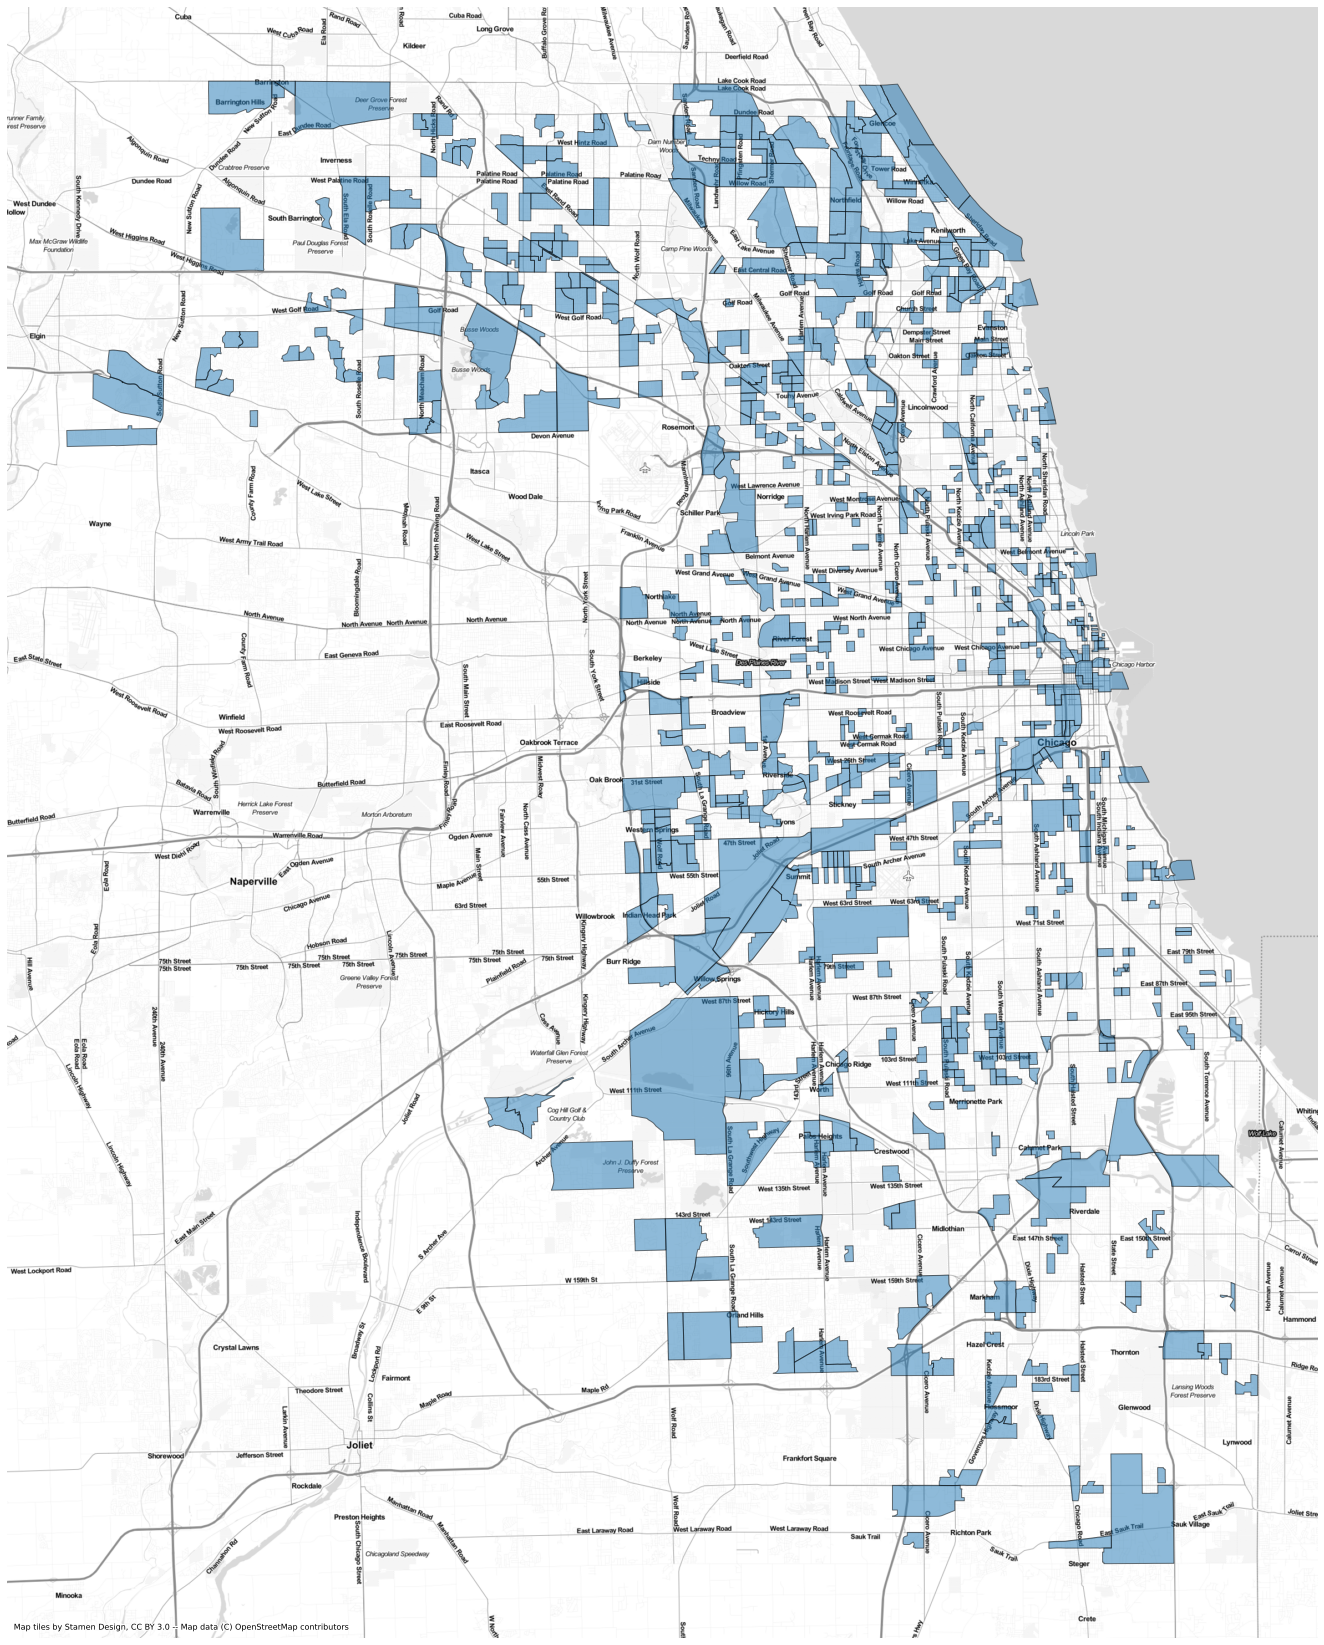

In [16]:
ax = top10_pre_df.plot(figsize=(30, 30), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite, zoom = 12)
ax.set_axis_off()


<ipython-input-17-8ab440e45215>:2: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite, zoom = 12)


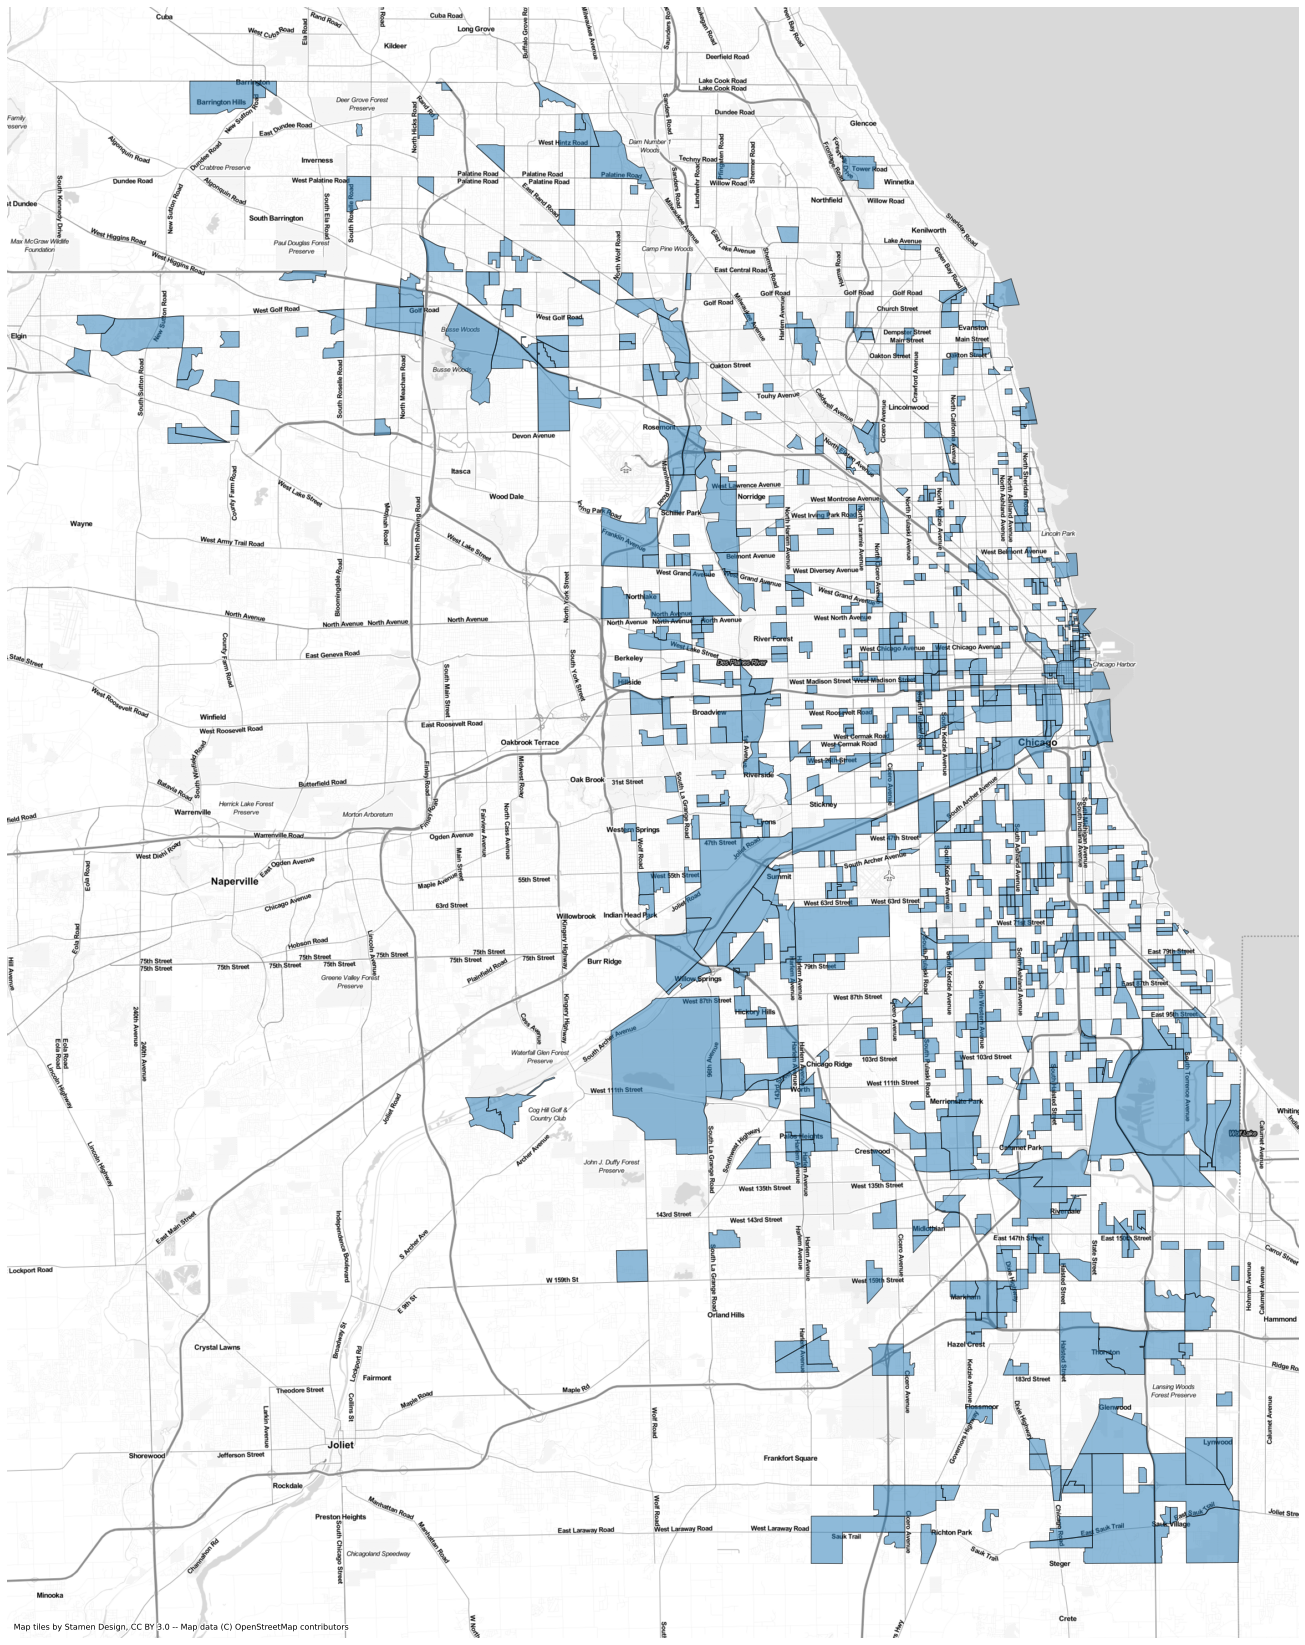

In [17]:
ax = top10_post_df.plot(figsize=(30, 30), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite, zoom = 12)
ax.set_axis_off()